# Artificial Intelligence FS 2022

## Automatic Classification of Pneunomia based on X-rays

---

The exercise is about train a supervised learning algorithm (CNN) for the detection of pneumonia based on image features extracted from pre-trained CNN models. Along this project, there are different subtasks to be done. Each of these subtasks are going to be explained on detail below. Your task is to fill this jupyter notebook.

## Tasks
1. **Transfer Learning**: consider using different pre-trained CNN architectures for extracting the image features. For a complete overview of different pre-trained architectures have a look at [CNN-zoo](https://pytorch.org/vision/stable/models.html). Repeat the training and evaluating/fine-tuning process.
2. **Experimental evaluation**: use different CNN architectures and compare their accuracies. Also fine-tune them properly and evaluate their results. Which one performed best? What is the intuition behind? Some examples of CNN architecture include: VGG-16, ResNet50, ShuffleNetv2, EfficientNets. Also, what happens if your train your models from scratch, instead of finetuning them?
3. Summarize what are the strenghts and weaknesses of each of the implemented models.Which architectures help the most and why? 
4. Given the fact that the dataset is skewed (more samples from one class than the other), how can you tackle the problem of class imbalance? Proof that your idea works by implementing it.
5. One key aspect when dealing with AI models is the interpretability of their results. As such, investigate: ($i$) how the trained filters look like (visualise the learned weights),  ($ii$) use class activation maps (CAMs) to visualise which parts of the image are used for pneunomia classification?
6. Instead of fine-tuning your CNN models, extract feature vectors from your pre-trained CNN models by feeding them with the images and feed-forwarding the images through the model. Next, we collect feature vectors from the FC layers of the model. The collection of those vetors will represent the new dataset, over which we will train different ML classifiers (e.g. Random Forest, XGBoost ). Compare their classification results and also against the results obtained from the transfer-learning approach [BONUS].

**CNN description:** In the Figure below, you find different CNN architectures pre-trained on the Imagenet dataset. Their top-1 accuraries are visualied on the y-axis, whilst their number of parameters in the x-axis. Most of these pre-trained models are available at pytorch's [CNN-zoo](https://pytorch.org/vision/stable/models.html).

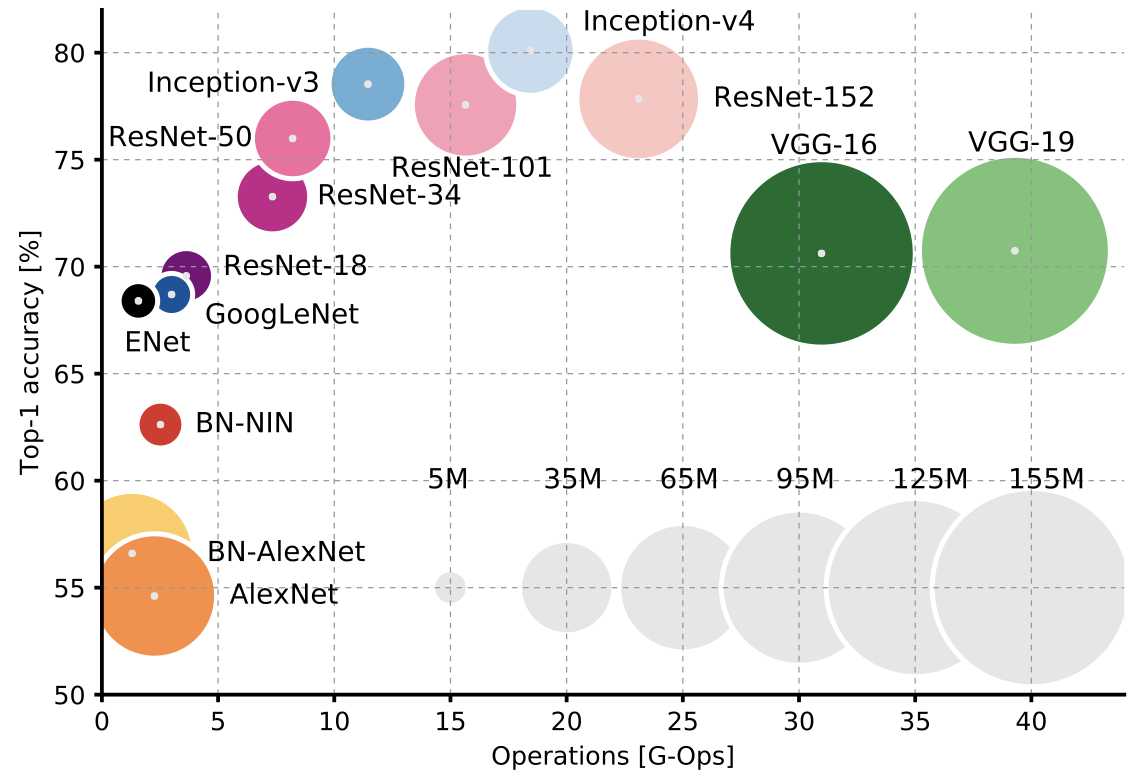

## Dataset Overview

* The Pneunomia dataset contains x-rays from patients being ``normal`` or having ``pneunomia``.

## Importing Libraries

In [59]:
!pip install scikit-plot

In [60]:
!pip install grad-cam

In [61]:
!pip install pandas
!pip install seaborn
!pip install torchsummary

In [62]:
import time
import os
import copy

import numpy as np
import PIL as PIL
import pandas as pd
import seaborn as sns
import scikitplot as skplt

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.utils import class_weight
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image


## Global Settings

In [63]:
data_dir = 'chest_xray_db'
categories = ['train','val','test']
batch_size = 16
num_workers = 8

# Hyperparameters
learning_rate = 0.001
num_epochs = 1 # TODO change to 10

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Dataset

### Obtaining  Dataset

In [64]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [65]:
# !unzip -q /content/drive/MyDrive/health_2021/covid_db/chest_xray.zip

In [66]:
!ls chest_xray_db

Der Befehl "ls" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


In [67]:
plt.ion() 

use_gpu = torch.cuda.is_available()
device = torch.device('cuda' if use_gpu else 'cpu')
if use_gpu:
    print("Using CUDA")
else:
    print("Using CPU")

Using CPU


In [68]:
# shows the number of batch size images and corresponding labels for each image.
# takes images and names of the images as parameters
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


### Preparing  Dataset

In [69]:
# You should create a composite of transformations that are going to be applied on the training/test images.
# As the
# resolution of the images varies, all images have to be resized to 224x224 pixels. Next,
# you should normalise the image pixels to the [0,1] and, afterwards, normalise the data to
# zero-mean and standard-deviation using the pre-defined values given by (mean_values, std_values).
# Hint: Have a look at transforms.Compose(), transforms.ToTensor() and related functions.

mean_values = [0.485, 0.456, 0.406]
std_values = [0.229, 0.224, 0.225]

# data augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)), # resize to 224x224
        transforms.ToTensor(), # normalize pixel to 0,1
        transforms.Normalize(mean_values, std_values) # normalize
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean_values, std_values)
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean_values, std_values)
    ]),
}

In [70]:
# loads the images from test and train folders who are in dataset folder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in categories}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=num_workers) for x in categories}
dataset_sizes = {x: len(image_datasets[x]) for x in categories}
class_names = image_datasets['train'].classes
num_classes = len(class_names)

In [71]:
image_datasets['val'].classes

['healthy', 'pneunomia']

In [72]:
image_datasets['test'].classes

['healthy', 'pneunomia']

In [73]:
class_names

['healthy', 'pneunomia']

In [74]:
for cate in categories:
  print('Dataset split \'{}\' number of images: {}'.format(cate, dataset_sizes[cate]))

Dataset split 'train' number of images: 2624
Dataset split 'val' number of images: 226
Dataset split 'test' number of images: 228


In [75]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

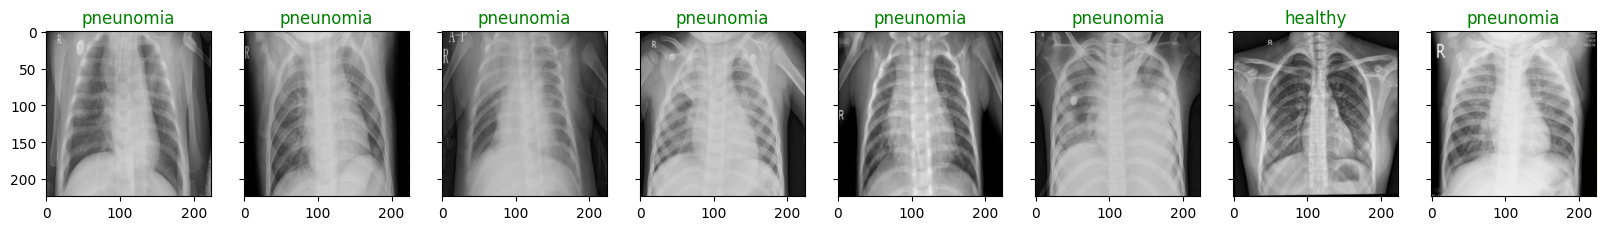

In [76]:
# Visualize some training images
n_images = 8

fig, axes = plt.subplots(nrows=1, ncols=n_images, sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = inputs[:n_images]

for ii in range(n_images):
    curr_img = orig_images[ii].detach().to(device)
    curr_img = curr_img.permute((1, 2, 0)).cpu().numpy()

    mean = np.array(mean_values)
    std = np.array(std_values)
    curr_img = std * curr_img + mean
    curr_img = np.clip(curr_img, 0, 1)

    axes[ii].imshow(curr_img)
    axes[ii].set_title('{}'.format(class_names[classes[ii]]), color='green')


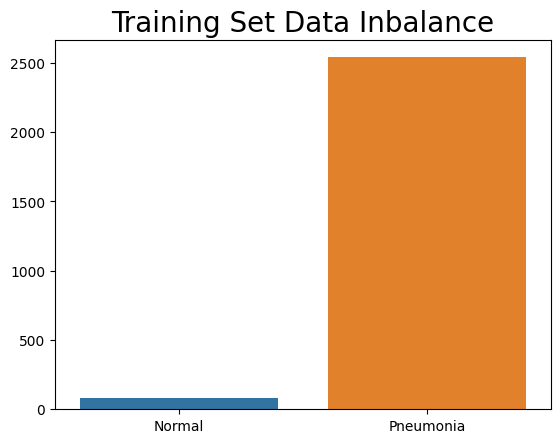

In [77]:
train_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(data_dir+'/train/healthy', filename)
                     for filename in os.listdir(data_dir+'/train/healthy')])],
     'Pneumonia': [len([os.path.join(data_dir+'/train/pneunomia', filename)
                        for filename in os.listdir(data_dir+'/train/pneunomia')])]})


sns.barplot(data=train_samplesize).set_title('Training Set Data Inbalance', fontsize=20)
plt.show()

## Deep Learning Pipeline

### Model Definition

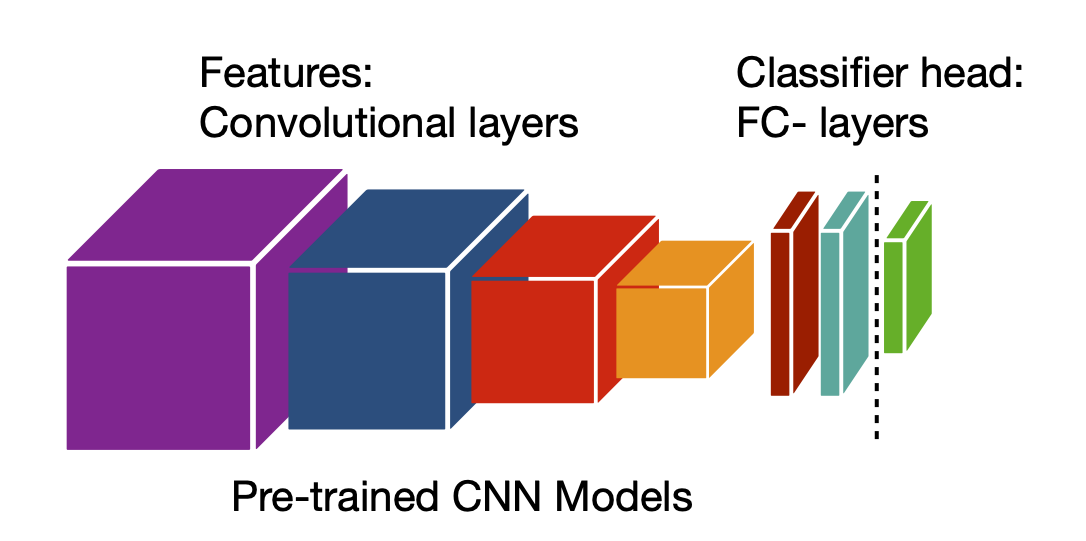

In [78]:
class COVID_CNN(torch.nn.Module):
  def __init__(self, num_classes=num_classes):
      super(COVID_CNN, self).__init__()
      self.model = torchvision.models.resnet152(weights='DEFAULT')
      self.freeze()
      self.classifier = nn.Sequential(
            nn.Linear(self.model.fc.in_features, num_classes),
      )
      self.model.fc = self.classifier

  def freeze(self):
      for param in self.model.parameters():
          param.requires_grad = False

  def forward(self, x):
      logits = self.model(x) # copied
      probas = torch.softmax(logits, dim=1) #copied
      return logits, probas

In [79]:
# initialise model
model = COVID_CNN(num_classes=num_classes)
print(model)

COVID_CNN(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

In [80]:
from torchsummary import summary
summary(model.model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

### Loss function
Pytorch provides the 
[torch.nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss)
loss function that computes the softmax followed by the cross entropy.

Consider a 3-class problem. Let us take
an input, of true class y=1, being assigned the scores
$\hat{z} = [-100, 10, 8]$, i.e. the assigned probabilities being
$\hat{y} = [\frac{\exp(-100)}{\sum_i \exp(y_i)}, \frac{\exp(10)}{\sum_i \exp(y_i)}, \frac{\exp(8)}{\sum_i \exp(y_i)}] = [0.0000, 0.8808, 0.1192]$
the cross entropy loss is given by $-\sum_{i=0}^{3} \log(\hat{y}_y) = -\log(0.8808) \approx 0.1269$
and is computed in Pytorch as :

``` {.sourceCode .python}
f_loss = torch.nn.CrossEntropyLoss()
f_loss(torch.Tensor([[-100, 10, 8]]), torch.LongTensor([1]))
# This prints :   torch.Tensor(0.1269)
```

For now, back to our experiment, we just need to instantiate the loss :

``` {.sourceCode .python}
f_loss = torch.nn.CrossEntropyLoss()
```

In [81]:
#class_weights = class_weight.compute_class_weight('balanced', np.unique(y), y.numpy())
class_weights = torch.tensor([10.0, 1.0],dtype=torch.float)


In [82]:
f_loss = torch.nn.CrossEntropyLoss(weight=class_weights)

### Optimizer
In order to update the model parameters using the computed gradients (`backward()`), we need  to define an optimizer which as its names says, it optimizes the parameters of a neural network is
performed by some kind of gradient descent. In PyTorch there are different optimizers
provided in the [torch.optim
package](https://pytorch.org/docs/stable/optim.html). We will focus on the
[Adam
optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam), which is one of the most common and stable optimizers. To know more about optimizers, there is a [compendium of optimizers
provided by Sebastian
Ruder](http://ruder.io/optimizing-gradient-descent/index.html). 

Note that the optimizer needs a reference to the parameters that it needs
to modify.

```
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
```

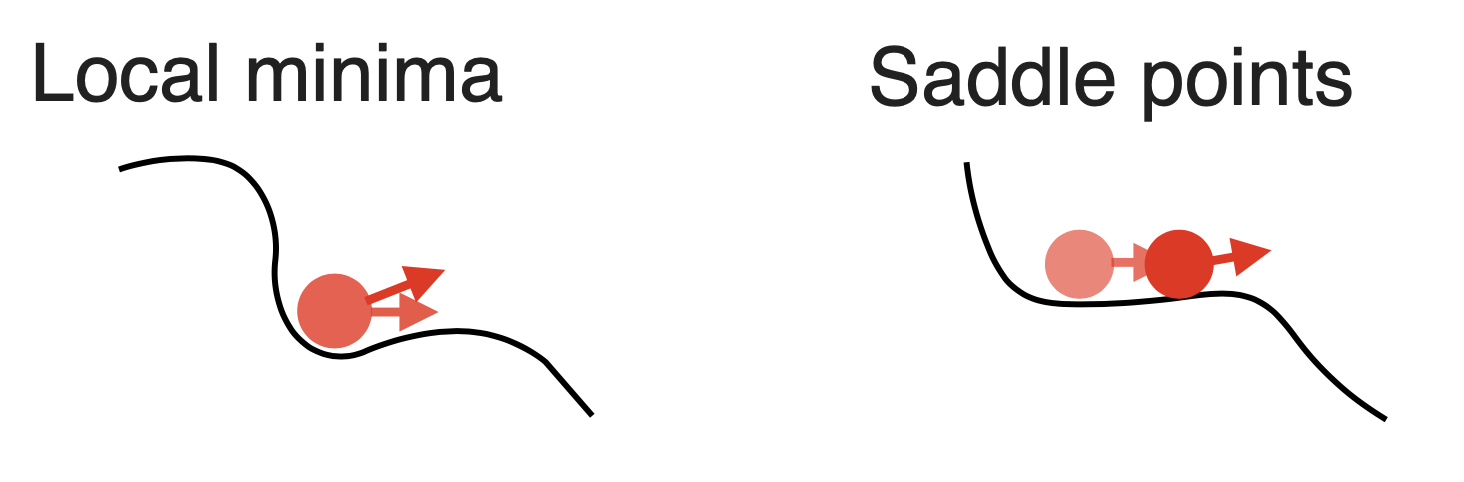

In [83]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Scheduler
Use a StepLR scheduler to train your model (StepLR)

In [84]:
from torch.optim.lr_scheduler import StepLR

scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

### Model Training
Training a neural network involves iterating over the mini-batches of the training set and, for each mini-batch, computing the forward- and backward- propagations to provide the optimizer the gradient from which it can update the model parameters.


- Learning Process:
    1. Put inputs/labels into GPU device.
    2. Do forward propagation => Predictions
    3. Compute Loss function
    4. Do backward propagation => Gradients w.r.t. parameters
    5. Update parameters using gradients
        - `parameters = parameters - learning_rate * parameters_gradients`
    6. REPEAT learning process

In [85]:
def compute_accuracy_and_loss(model, data_loader, device):
    
    correct_pred, num_examples = 0, 0
    
    cross_entropy = 0.

    predictions_arr = []
    targets_arr  = []

    for ii, (features, targets) in enumerate(data_loader):
            
        features = features.to(device) # x to device
        targets = targets.to(device) # y to device

        logits, probas = model(features) # forward propagation z=logits, a=f(z)
        cross_entropy += F.cross_entropy(logits, targets).item()
        #cross_entropy += F.nll_loss(torch.log(probas), targets)

        _, predicted_labels = torch.max(probas, 1) # y_hat=predicted_labels
        num_examples += targets.size(0)

        correct_pred += (predicted_labels == targets).sum()
        targets_arr.append(targets)
        predictions_arr.append(predicted_labels)

    return correct_pred.float()/num_examples * 100, cross_entropy/num_examples, targets_arr, predictions_arr

In [86]:
def train(model, num_epochs, train_loader, valid_loader):
  
  minibatch_cost = []
  train_acc_lst, valid_acc_lst = [], []
  train_loss_lst, valid_loss_lst = [], []

  best_acc = 0
  best_loss = np.inf

  start_time = time.time()
  for epoch in range(num_epochs):

      model.train()

      for batch_idx, (features, targets) in enumerate(train_loader):
          
          features = features.to(device) 
          targets = targets.to(device)
              
          # forward-propagation
          logits, probas = model.forward(features)

          # compute cost function
          cost = F.cross_entropy(logits, targets)

          # clean gradients
          optimizer.zero_grad()
          
          # compute derivatives
          cost.backward()

          # append minibatch cost
          minibatch_cost.append(cost.item())
          
          # update model parameters
          optimizer.step() # w = w - learning_rate * partial_deriv_error
          
          # logging results
          if not batch_idx % 50:
              print ('Epoch: %05d/%05d | Batch %05d/%05d | Cost: %.4f' 
                    %(epoch+1, num_epochs, batch_idx, 
                      len(train_loader), cost))
      scheduler.step()
              
      with torch.set_grad_enabled(False):
          train_acc, train_loss, train_targets, train_preds = compute_accuracy_and_loss(model, train_loader, device=device) # compute accuracy and loss on train dataset
          valid_acc, valid_loss, valid_targets, valid_preds = compute_accuracy_and_loss(model, valid_loader, device=device) # compute accuracy and loss on validation dataset

          print('Epoch: %05d/%05d | Train cost: %.4f | Valid cost: %.4f | Train acc.: %.4f%% | Val.acc.: %.4f%%' % (
                epoch+1, num_epochs, 
                train_loss,
                valid_loss,
                train_acc,
                valid_acc))
          
          train_acc_lst.append(train_acc)
          valid_acc_lst.append(valid_acc)
          train_loss_lst.append(train_loss)
          valid_loss_lst.append(valid_loss)

          
      print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
      
  print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

  return minibatch_cost, train_loss_lst, valid_loss_lst, train_acc_lst, valid_acc_lst

In [87]:
minibatch_cost, train_loss_lst, valid_loss_lst, train_acc_lst, valid_acc_lst = train(model, num_epochs, dataloaders['train'], dataloaders['val']) # do training

Epoch: 00001/00001 | Batch 00000/00164 | Cost: 0.6548
Epoch: 00001/00001 | Batch 00050/00164 | Cost: 0.0253
Epoch: 00001/00001 | Batch 00100/00164 | Cost: 0.0458
Epoch: 00001/00001 | Batch 00150/00164 | Cost: 0.0548
Epoch: 00001/00001 | Train cost: 0.0035 | Valid cost: 0.0104 | Train acc.: 97.9421% | Val.acc.: 95.1327%
Time elapsed: 31.49 min
Total Training Time: 31.49 min


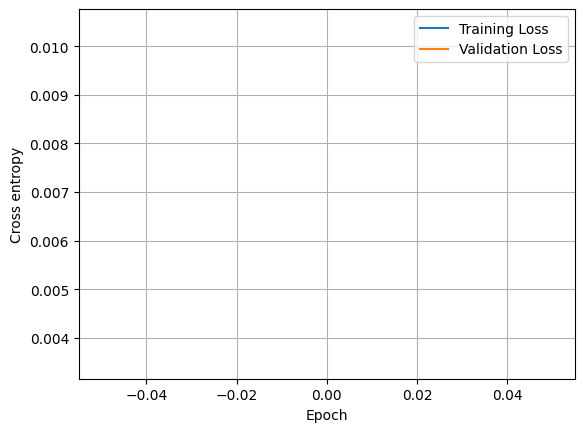

In [88]:
plt.plot(range(len(train_loss_lst)), (train_loss_lst), label='Training Loss')
plt.plot(range(len(valid_loss_lst)), (valid_loss_lst), label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.grid()
plt.show()

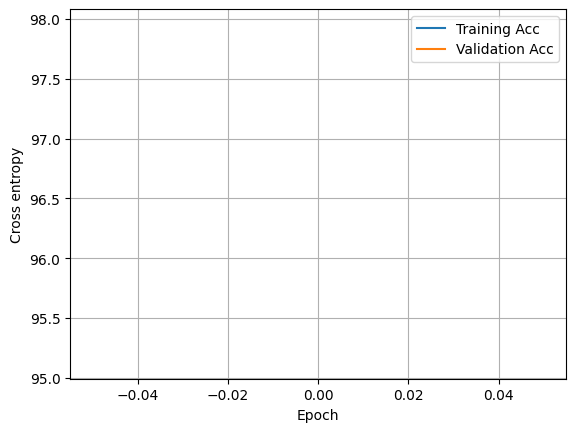

In [89]:
plt.plot(range(len(train_acc_lst)), train_acc_lst, label='Training Acc')
plt.plot(range(len(valid_acc_lst)), valid_acc_lst, label='Validation Acc')
plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.grid()
plt.show()

### Model Evaluation
Once you've trained your model, you're asked to 

In [90]:
test_acc, test_loss, test_targets, test_preds = compute_accuracy_and_loss(model, dataloaders['test'], device=device) # compute accuracy on test dataset
print('Test accuracy: %.2f%%' % (test_acc))

Test accuracy: 76.32%


In [91]:
test_targets = torch.hstack(test_targets).cpu().detach().numpy()
test_preds = torch.hstack(test_preds).cpu().detach().numpy()

In [92]:
print(test_targets.shape)
print(test_preds.shape)

(228,)
(228,)


<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

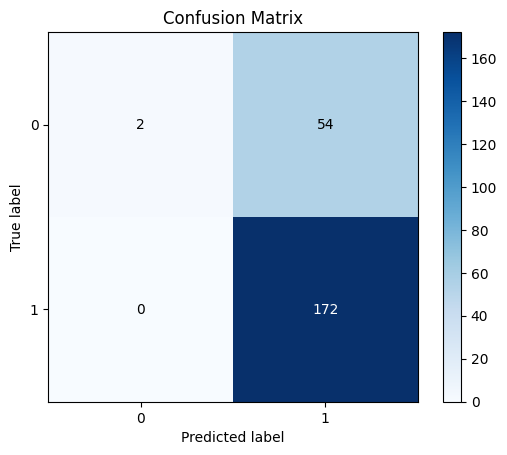

In [93]:
skplt.metrics.plot_confusion_matrix(test_targets,test_preds, normalize=False)

In [94]:
for ii in range(len(class_names)):
    correct = ((test_targets == ii)*1) * ((np.array(test_preds) == test_targets)*1)
    print('{}, {}: '.rjust(10).format(ii, class_names[ii]) + '{:.2f}%'.
          format(100*correct.sum()/test_targets[test_targets == ii].shape[0]))

  0, healthy: 3.57%
  1, pneunomia: 100.00%


In [96]:
# obtain one batch of test images
data_iter = iter(dataloaders['test'])
images, targets = next(data_iter)

In [100]:
# get sample outputs
logits, probas = model(images.to(device))

# convert output probabilities to predicted class
_, preds = torch.max(probas, 1)

In [101]:
# Visualise some predicted images
fig = plt.figure(figsize=(25, 15))
for idx in np.arange(len(images)):
    ax = fig.add_subplot(5, 50/5, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx].numpy(), (1, 2, 0)))
    ax.set_title("{} ({})".format(class_names[preds[idx]], class_names[targets[idx]]),
                 color=("green" if preds[idx]==targets[idx].item() else "red"))

ValueError: Number of columns must be a positive integer, not 10.0

<Figure size 2500x1500 with 0 Axes>

## Interpretability
Interpreting how the CNN model obtained its predictions helps to gain trust on the applicability of AI for specific tasks. To do so, investigate: ($i$) how the trained filters look like (visualise the learned weights),  ($ii$) use class activation maps (CAM or more recent techniques) to visualise which parts of the image were actived more for solving our image classification task?



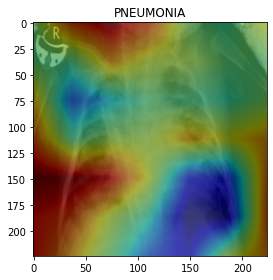

## Machine Learning Pipeline [BONUS]
Instead of fine-tune your CNN model, extract a Feature Vector and use  ML classifiers (e.g. Random Forest, XGBoost ) to classify the images based on the extracted features. Compare their results and also against the statistics extracted from the transfer-learning approach. 
A Figure explaining the ML Pipeline is given below. 
Hint: use the sklearn library to train your different classifiers, e.g. [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), [XGBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html). For hyperparameter tuning, use sklearn [grid-search](https://scikit-learn.org/stable/modules/grid_search.html). In this approach, you feed the batches onto your pre-trained CNN models (feed-forward propagation). You can collect these vectors and use them as training inputs for your ML models.

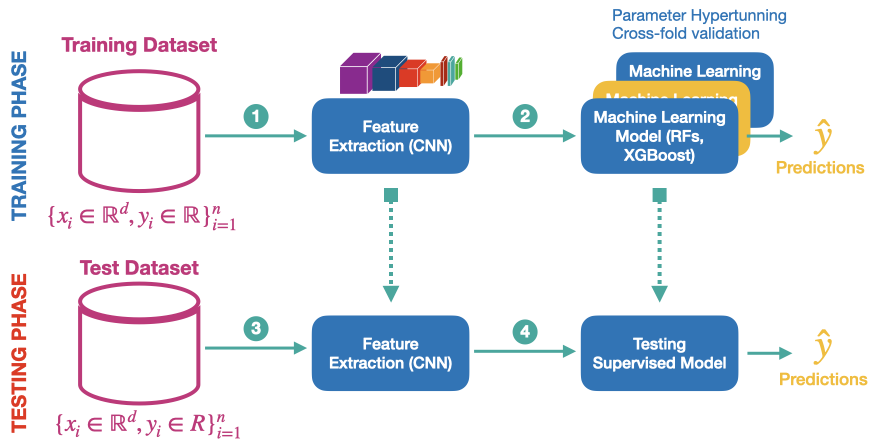

# Stefans Part
One key aspect when dealing with AI models is the interpretability of their results. As such, investigate: ($i$) how the trained filters look like (visualise the learned weights),  ($ii$) use class activation maps (CAMs) to visualise which parts of the image are used for pneunomia classification?


### Visualize the model's architecture and learned weights

In [ ]:
!brew install graphviz
!pip install torchviz

from torchviz import make_dot

logits, probas = model(images.to(device))
make_dot(probas.mean(), params=dict(model.named_parameters()))

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms, utils
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
from PIL import Image
import json
%matplotlib inline


In [ ]:
model_weights =[] 
conv_layers = [] 

# model_children = list(model.children()) # doesn't work because of inner model

# 2x model because of inner model!
model_children = list(model.model.children())

counter = 0 
for i in range(len(model_children)): 
    if type(model_children[i]) == nn.Conv2d: 
        counter+=1 
        model_weights.append(model_children[i].weight) 
        conv_layers.append(model_children[i]) 
    elif type(model_children[i]) == nn.Sequential: 
        for j in range(len(model_children[i])): 
            for child in model_children[i][j].children(): 
                if type(child) == nn.Conv2d: 
                    counter+=1 
                    model_weights.append(child.weight) 
                    conv_layers.append(child)

In [ ]:
import random
# To get image

test_iter = iter(dataloaders['test']) 
f_images, f_labels = next(test_iter) 
idx = round(random.randint(0, len(f_images) - 1)) 
f_image = f_images[idx] 
plt.imshow(np.transpose(f_image.numpy(), (1, 2, 0)))

In [ ]:
outputs = [] 
names = [] 
r_image = f_image.to(device) 
for layer in conv_layers[0:]: 
    r_image = layer(r_image) 
    outputs.append(r_image) 
    names.append(str(layer))

In [ ]:
processed = [] 
for feature_map in outputs: 
    feature_map = feature_map.squeeze(0) 
    gray_scale = torch.sum(feature_map,0) 
    gray_scale = gray_scale / feature_map.shape[0] 
    processed.append(gray_scale.data.cpu().numpy())

In [ ]:
import math
fig = plt.figure(figsize=(25, 40)) 
for i in range(len(processed)): 
    a = fig.add_subplot(math.floor(counter / 10) + 1, 10, i+1) 
    imgplot = plt.imshow(processed[i]) 
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=8) 
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

### Generate CAMs for a trained CNN
According to: https://www.kaggle.com/code/antwerp/where-is-the-model-looking-for-gradcam-pytorch/notebook

In [ ]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git

In [ ]:
import copy
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet18
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torchvision

In [ ]:
for parameter in model.model.parameters():
      # Set true
  parameter.requires_grad = True

# Set model in eval mode
model.eval()

In [ ]:
input_tensor = f_image.unsqueeze(0)
c_img = transforms.ToPILImage()(f_image.cpu())
c_img = (c_img - np.min(c_img)) / (np.max(c_img) - np.min(c_img))

In [ ]:
with GradCAM(model=model.model, target_layers=[model.model.layer4[-1]], use_cuda=use_gpu) as cam:
  grayscale_c = cam(input_tensor=input_tensor)
  grayscale_cam = grayscale_c[0, :]
  cam_image = show_cam_on_image(c_img, grayscale_cam)
PIL.Image.fromarray(cam_image)